In [ ]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, auc, roc_curve, confusion_matrix

from surrogate_functions import get_data, print_evaluation_metrics, plot_most_important_features, plot_odds_ratio, PLTR

In [ ]:
X_encoded, y = get_data_step4()

In [8]:
xgb_model = joblib.load('../optimized_xgb_model.pkl')

preds_proba = xgb_model.predict_proba(X_encoded)[:, 1]
preds = (preds_proba >= 0.3).astype(int)

## Logistic Regression

In [10]:
logreg = LogisticRegression(max_iter=3000)
logreg.fit(X_encoded, preds)
surrogate_preds_proba = logreg.predict_proba(X_encoded)[:, 1] #probs of 1
surrogate_preds = logreg.predict(X_encoded)

/opt/homebrew/Caskroom/miniforge/base/envs/bike_counters/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Evaluating the surrogate

In [12]:
print_evaluation_metrics(preds, preds_proba, surrogate_preds, surrogate_preds_proba)

AUC: 0.7964739076323405
Accuracy score: 0.8771233875511399
Confusion matrix: [[791279  45487]
 [ 87986 161484]]
Mean squared error: 0.20595521170359435


### Interpreting the model

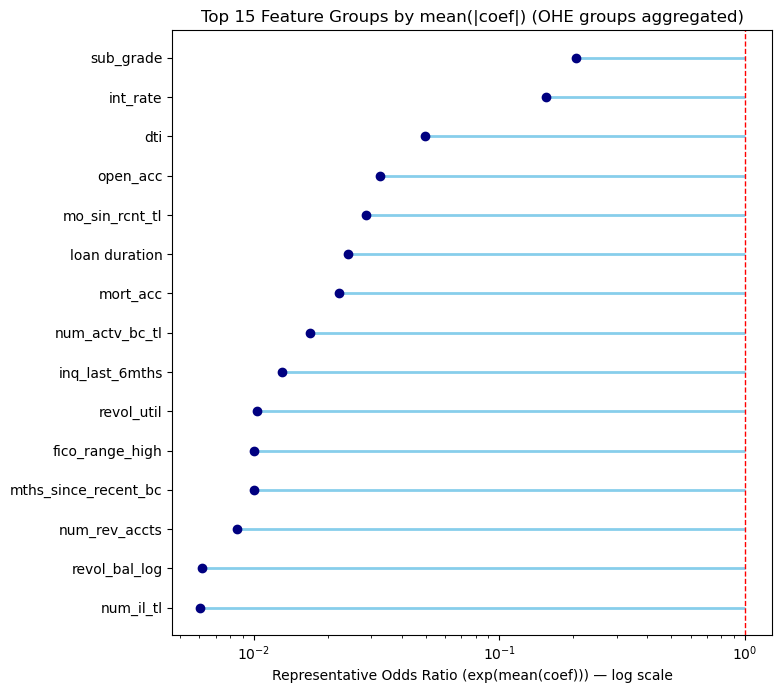

In [13]:
plot_most_important_features(logreg.coef_[0], X_encoded.columns)

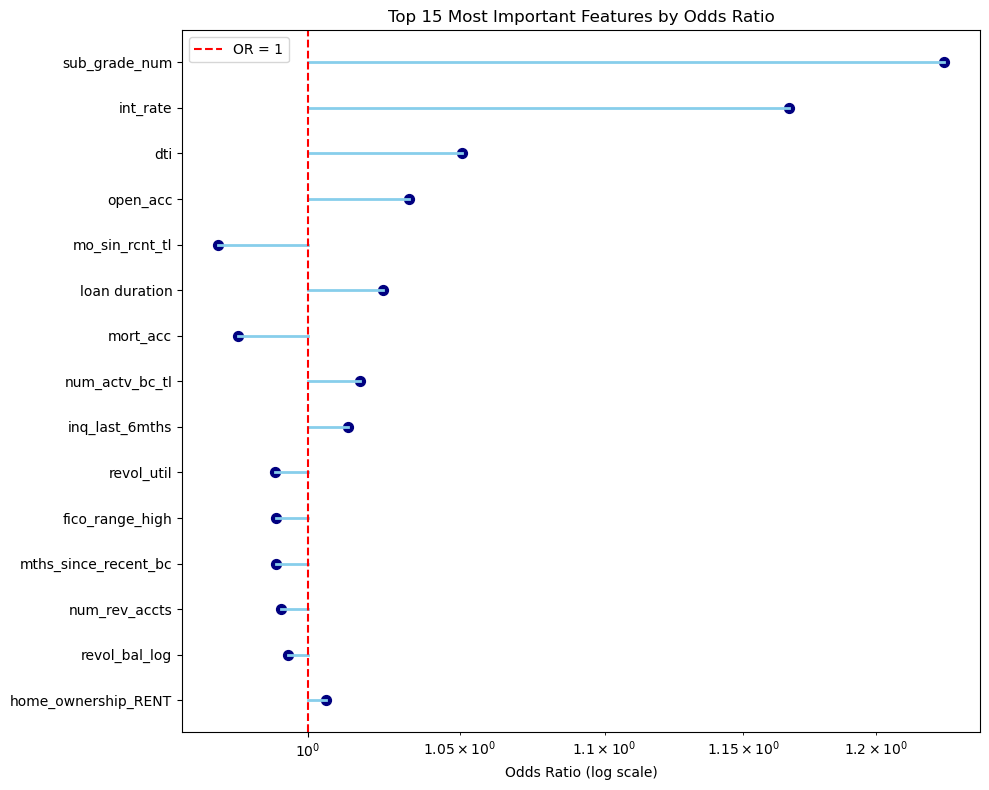

In [14]:
plot_odds_ratio(logreg.coef_[0], X_encoded.columns)

## Custom PLTR

In [ ]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pltr = PLTR(k=5, random_state=10, feature_names=X_encoded.columns)
pltr.fit(X_encoded, y, adaptive_lasso=True)

/Users/sam/Desktop/github-assignment/inte_stab_fair/test_cred/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,n_estimators,80
,max_depth,3
,random_state,10
,granularity,2
,k,5


In [ ]:
pltr.modified_input_full

In [ ]:
pltr_pred = pltr.predict(pltr.modified_input_full)
pltr_pred_prob = pltr.predict_proba(pltr.modified_input_full)[:, 1]

In [ ]:
print_evaluation_metrics(preds, preds_proba, pltr_pred, pltr_pred_prob)

In [ ]:
plot_most_important_features(pltr.pltr.coef_[0] * pltr.weights_alasso, pltr.modified_input_full.columns)

In [ ]:
plot_odds_ratio(pltr.pltr.coef_[0] * pltr.weights_alasso, pltr.modified_input_full.columns)

(0.8614436803481117,
 Predictions
 0.0    466532
 1.0    131441
 Name: count, dtype: int64)